# Regressione

In [1]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, KFold, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, RidgeCV
import seaborn.apionly as sns

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

# Esame del dataset Housing

Features:
    
<pre>
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000s
</pre>

Lettura del dataset in dataframe pandas

In [5]:
df = pd.read_csv('../dataset/housing.data.txt', header=None, sep='\s+')
df.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Visualizzazione delle caratteristiche del dataset

Matrice delle distribuzioni mutue delle feature. Sulla diagonale, distribuzione delle singole feature

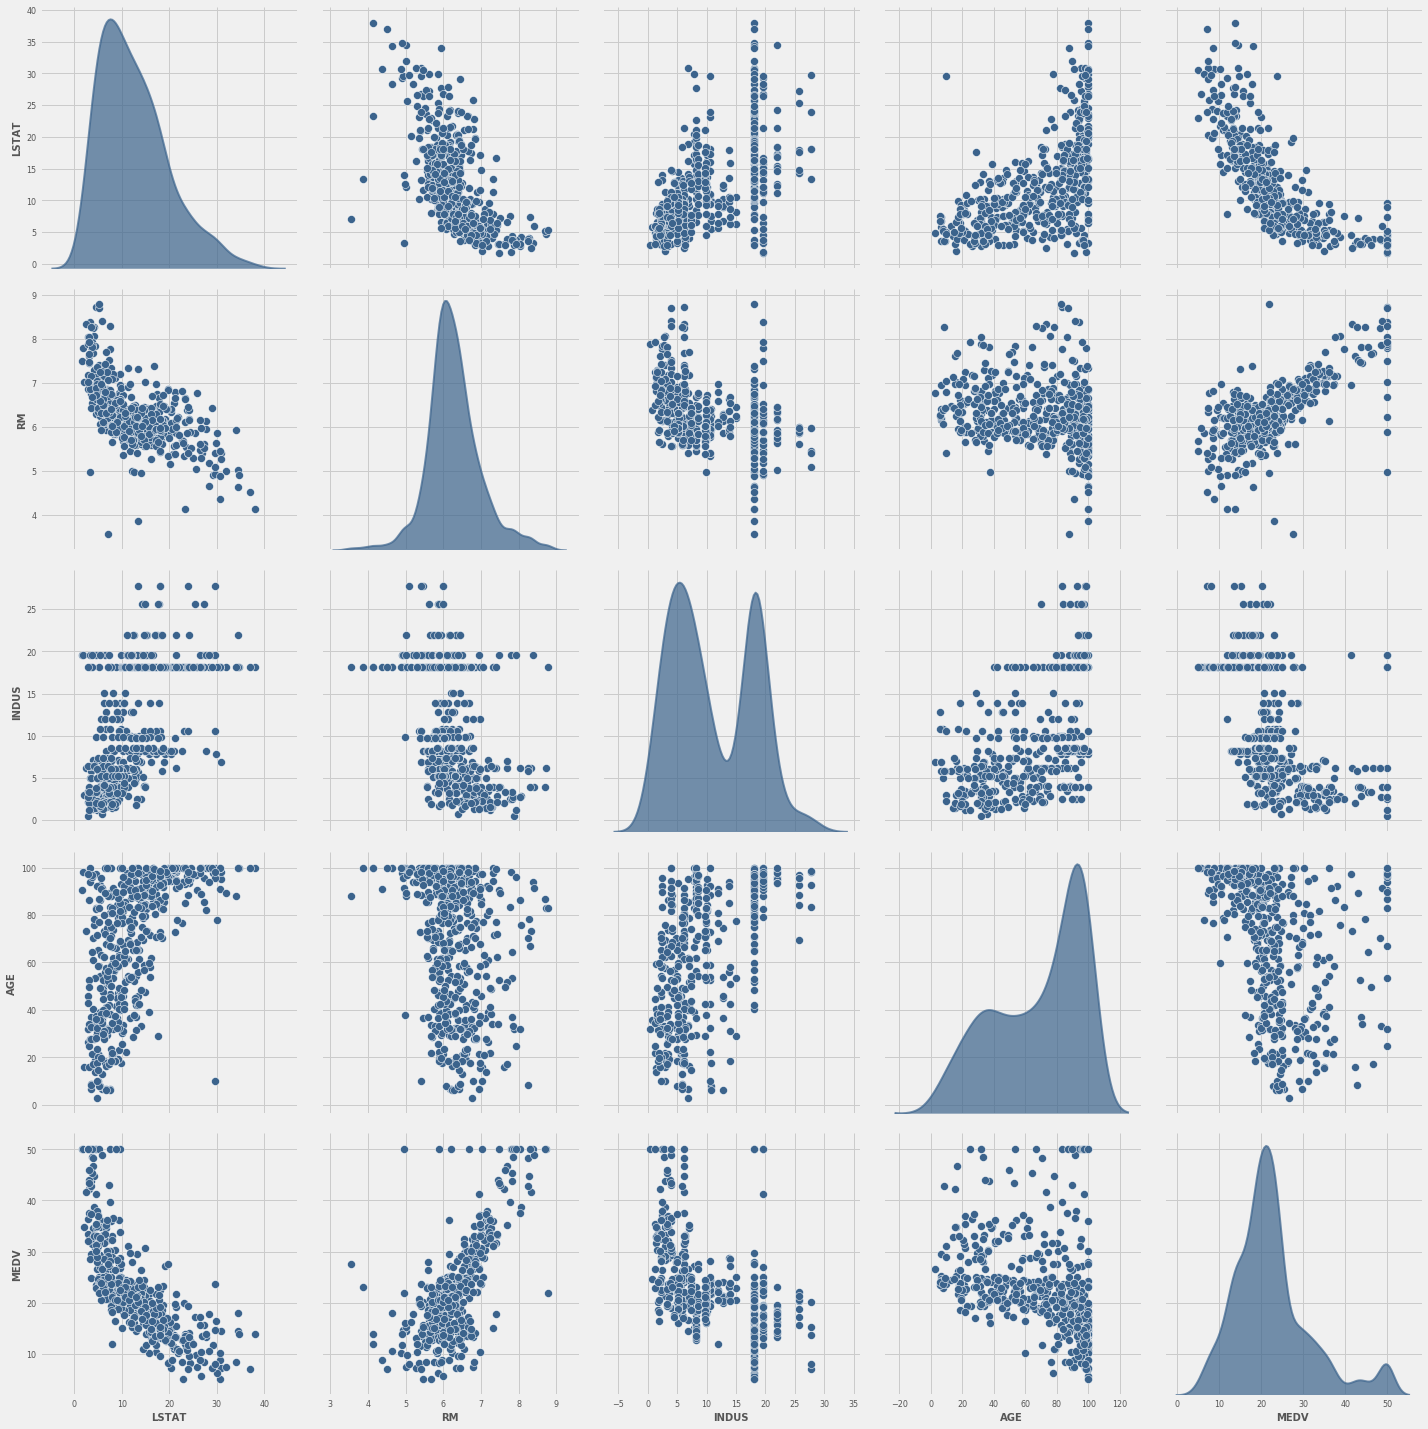

In [6]:
cols = ['LSTAT', 'RM', 'INDUS', 'AGE', 'MEDV']

fig = plt.figure(figsize=(16, 8))
sns.pairplot(df[cols], size=4, diag_kind='kde', 
             plot_kws=dict(color=colors[8]), 
             diag_kws=dict(shade=True, alpha=.7, color=colors[8]))
plt.show()

Visualizzazione della matrice di correlazione. Alla posizione $(i,j)$ il coefficiente di correlazione (lineare) tra le feature $i$ e $j$. Valore in $[-1,1]$: $1$ correlazione perfetta, $-1$ correlazione inversa perfetta, $0$ assenza di correlazione

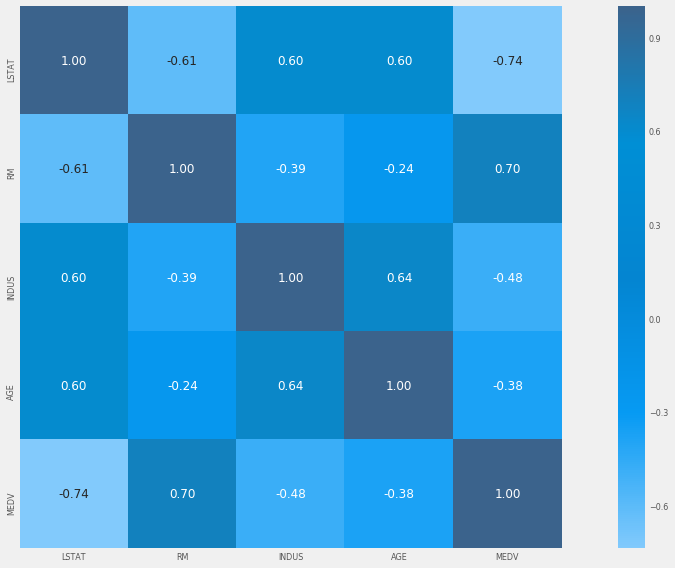

In [7]:
cm = np.corrcoef(df[cols].values.T)
plt.figure(figsize=(16,8))
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels=cols,
                 xticklabels=cols,
                 cmap = cmap)
plt.tight_layout()
plt.show()

### Regressione di MEDV rispetto a una sola feature

In [8]:
print('Feature utilizzabili: {0:s}'.format(list(df.columns[:-1])))

Feature utilizzabili: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [9]:
mi = mutual_info_regression(df[df.columns[:-1]], df[df.columns[-1]])
dmi = pd.DataFrame(mi, index=df.columns[:-1], columns=['mi']).sort_values(by='mi', ascending=False)
dmi.head(20)

,mi
LSTAT,0.667165
RM,0.524162
INDUS,0.478860
PTRATIO,0.464190
NOX,0.461180
TAX,0.376753
CRIM,0.341874
AGE,0.316766
DIS,0.297515
RAD,0.217222


Dichiara la feature da utilizzare

In [10]:
feat = 'RM'

In [11]:
X = df[[feat]].values
y = df['MEDV'].values

Regressione lineare standard: : la funzione di costo è $C(\mathbf{w})=\frac{1}{2}\sum_i ((y(\mathbf{w},\mathbf{x}_i) - t_i)^2$

In [12]:
r = LinearRegression()
r.fit(X, y)
mse = mean_squared_error(r.predict(X),y)

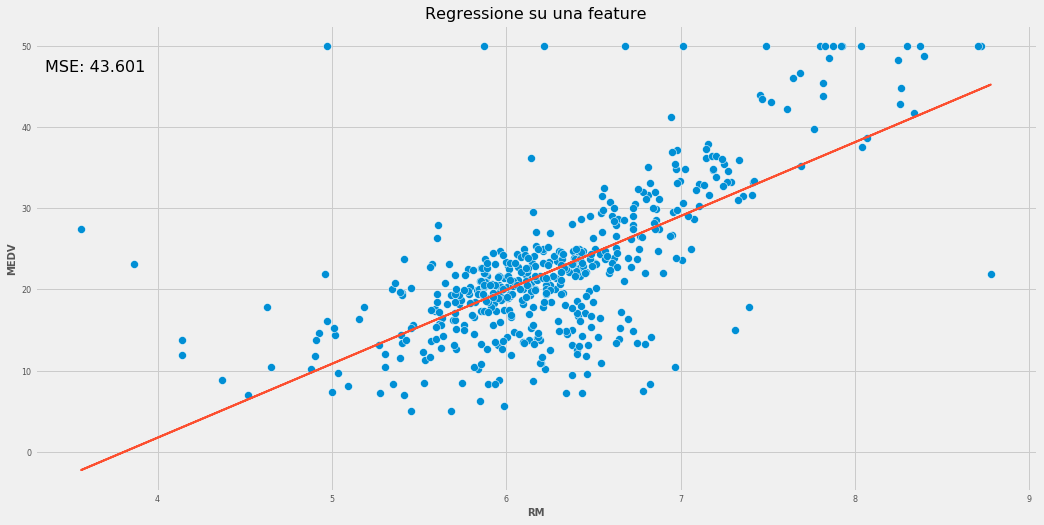

In [13]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[0], edgecolor='white')
plt.plot(X, r.predict(X), color=colors[1]) 
plt.text(0.01,0.9, r'MSE: {0:.3f}'.format(mse), transform = ax.transAxes, size=16)
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.title('Regressione su una feature', fontsize=16)
plt.show()

Valuta il modello su test set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [15]:
p = Pipeline([('regression', LinearRegression())])
r = p.fit(X_train, y_train)
mse_train = mean_squared_error(r.predict(X_train),y_train)
mse_test = mean_squared_error(r.predict(X_test),y_test)

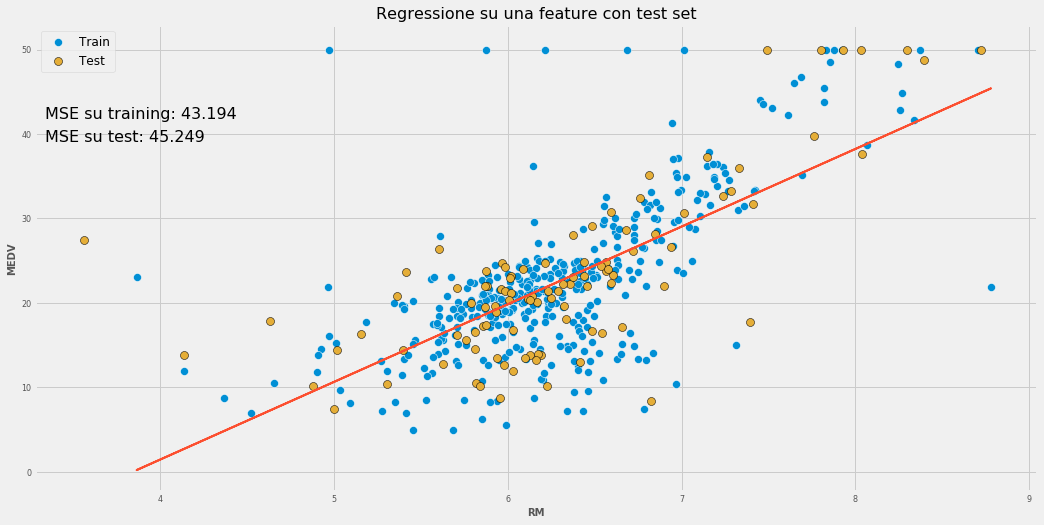

In [16]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X_train, y_train, c=colors[0], edgecolor='white', label='Train')
plt.scatter(X_test, y_test, c=colors[2], edgecolor='black', label='Test')
plt.plot(X_train, r.predict(X_train), color=colors[1]) 
plt.text(0.01,0.8, r'MSE su training: {0:.3f}'.format(mse_train), transform = ax.transAxes, size=16)
plt.text(0.01,0.75, r'MSE su test: {0:.3f}'.format(mse_test), transform = ax.transAxes, size=16)
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.title('Regressione su una feature con test set', fontsize=16)
plt.legend(fontsize=12)
plt.show()

Aggiungi standardizzazione della feature, modificandone i valori in modo da ottenere media $0$ e varianza $1$. Utilizza le pipeline di scikit-learn per definire una sequenza di task: in questo caso i dati sono normalizzati mediante uno StandardScaler e sui risultati viene applicato il modello di regressione.

In [17]:
p = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
r = p.fit(X_train, y_train)

# calcola errore quadratico medio su train set e su test set 
mse_train = mean_squared_error(r.predict(X_train),y_train)
mse_test = mean_squared_error(r.predict(X_test),y_test)

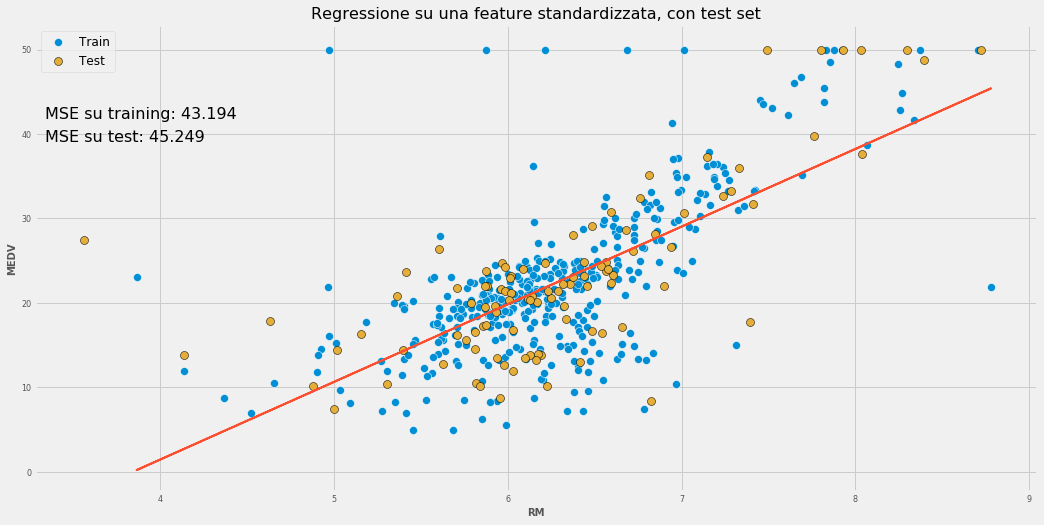

In [18]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X_train, y_train, c=colors[0], edgecolor='white', label='Train')
plt.scatter(X_test, y_test, c=colors[2], edgecolor='black', label='Test')
plt.plot(X_train, r.predict(X_train), color=colors[1]) 
plt.text(0.01,0.8, r'MSE su training: {0:.3f}'.format(mse_train), transform = ax.transAxes, size=16)
plt.text(0.01,0.75, r'MSE su test: {0:.3f}'.format(mse_test), transform = ax.transAxes, size=16)
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.legend(fontsize=12)
plt.title('Regressione su una feature standardizzata, con test set', fontsize=16)
plt.show()

Utilizzo della cross validation per valutare il modello. Si applica un KFold per suddividere il training set $X$ in n_splits coppie (training set, test set)

In [19]:
p = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
k_fold = KFold(n_splits=10)
coefs = []
# itera su tutte le coppie (training set - test set)
for train, test in k_fold.split(X):
    # effettua l'apprendimento dei coefficienti sul training set
    r = p.fit(X[train], y[train])
    # appende in una lista i coefficienti appresi e il costo quadratico medio sul test set
    coefs.append([r.named_steps['regression'].intercept_, r.named_steps['regression'].coef_[0], mean_squared_error(r.predict(X[test]),y[test])])
for i,c in enumerate(coefs):
    print('Fold: {0:2d}, w0: {1:.3f}, w1: {2:.3f}, MSE: {3:.3f}'.format(i, c[0],c[1],c[2]))
coefs = np.array(coefs)
m=np.mean(coefs, axis=0)
# restituisce le medie dei coefficienti e del MSE su tutti i fold
print('\nw0: {0:.3f}, w1: {1:.3f}, MSE: {2:.3f}'.format(m[0],m[1],m[2]))

Fold:  0, w0: 22.762, w1: 6.531, MSE: 15.073
Fold:  1, w0: 22.333, w1: 6.524, MSE: 5.171
Fold:  2, w0: 23.031, w1: 6.583, MSE: 10.836
Fold:  3, w0: 21.558, w1: 5.589, MSE: 64.070
Fold:  4, w0: 21.950, w1: 6.003, MSE: 18.065
Fold:  5, w0: 21.538, w1: 5.533, MSE: 36.775
Fold:  6, w0: 22.608, w1: 6.626, MSE: 3.871
Fold:  7, w0: 23.091, w1: 6.912, MSE: 210.756
Fold:  8, w0: 23.511, w1: 6.738, MSE: 115.595
Fold:  9, w0: 22.941, w1: 6.605, MSE: 19.467

w0: 22.532, w1: 6.364, MSE: 49.968


Utilizza la funzione cross_val_score di scikit-learn per effettuare la cross validation

In [20]:
p = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
# apprende il modello su tutto il training set
r = p.fit(X, y)
# calcola costo derivante dall'applicazione del modello su ttto il dataset, quindi con possibile overfitting
mse = mean_squared_error(r.predict(X),y)
# effettua la cross validation, derivando il costo sul test set per tutti i fold
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
# calcola costo medio su tutti i fold
mse_cv = -scores.mean()

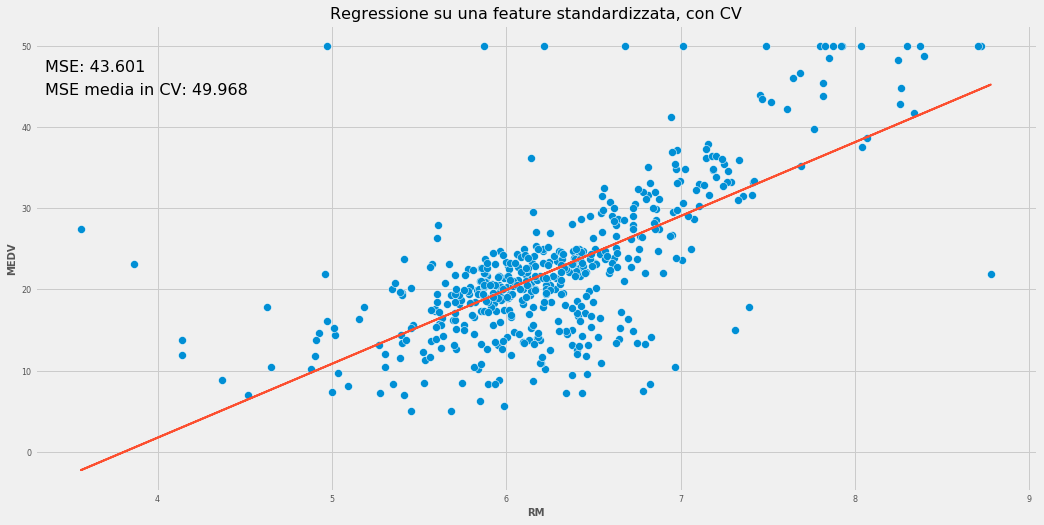

In [21]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[0], edgecolor='white')
plt.plot(X, r.predict(X), color=colors[1]) 
plt.text(0.01,0.9, r'MSE: {0:.3f}'.format(mse), transform = ax.transAxes, size=16)
plt.text(0.01,0.85, r'MSE media in CV: {0:.3f}'.format(mse_cv), transform = ax.transAxes, size=16)
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.title('Regressione su una feature standardizzata, con CV', fontsize=16)
plt.show()

### Regressione con regolazione

Utilizza un modello con regolazione L1 (Lasso): la funzione di costo è $C(\mathbf{w})=\frac{1}{2}\sum_i ((y(\mathbf{w},\mathbf{x}_i) - t_i)^2+\frac{\alpha}{2}\sum_j |w_j|$. 

In [22]:
alpha = 0.5
p = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha=alpha))])
r = p.fit(X, y)
mse = mean_squared_error(r.predict(X),y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
mse_cv = -scores.mean()

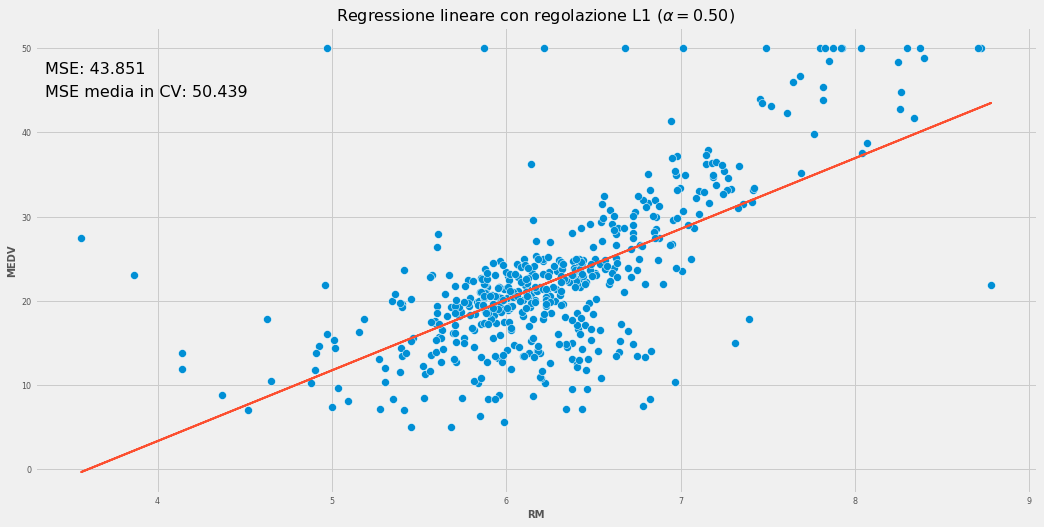

In [23]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[0], edgecolor='white')
plt.plot(X, r.predict(X), color=colors[1]) 
plt.text(0.01,0.9, r'MSE: {0:.3f}'.format(mse), transform = ax.transAxes, size=16)
plt.text(0.01,0.85, r'MSE media in CV: {0:.3f}'.format(mse_cv), transform = ax.transAxes, size=16)
plt.xlabel(feat)
plt.ylabel('MEDV')
plt.title(r'Regressione lineare con regolazione L1 ($\alpha={0:.2f}$)'.format(alpha), fontsize=16)
plt.show()

Applica un modello con regolazione L2 (Ridge): la funzione di costo è $C(\mathbf{w})=\frac{1}{2}\sum_i ((y(\mathbf{w},\mathbf{x}_i) - t_i)^2+\frac{\alpha}{2}\sum_j w_j^2$

In [24]:
alpha = 0.5
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha=alpha))])
r = p.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')

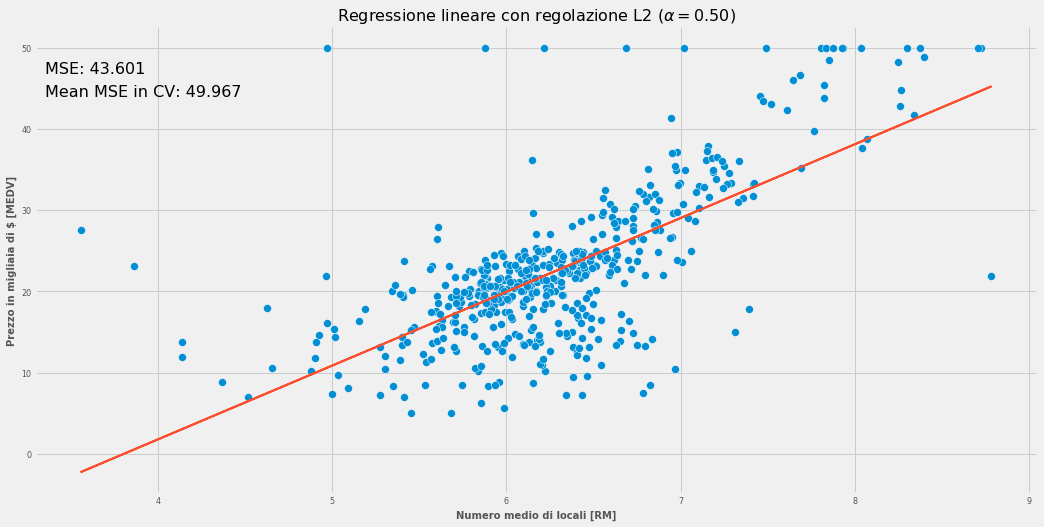

In [25]:
mse = mean_squared_error(r.predict(X),y)
mse_cv = -scores.mean()
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[0], edgecolor='white')
plt.plot(X, r.predict(X), color=colors[1]) 
plt.text(0.01,0.9, r'MSE: {0:.3f}'.format(mse), transform = ax.transAxes, size=16)
plt.text(0.01,0.85, r'Mean MSE in CV: {0:.3f}'.format(mse_cv), transform = ax.transAxes, size=16)
plt.xlabel('Numero medio di locali [RM]')
plt.ylabel('Prezzo in migliaia di $ [MEDV]')
plt.title(r'Regressione lineare con regolazione L2 ($\alpha={0:.2f}$)'.format(alpha), fontsize=16)
plt.show()

Applica un modello con regolazione Elastic Net: la funzione di costo è $C(\mathbf{w})=\frac{1}{2}\sum_i ((y(\mathbf{w},\mathbf{x}_i) - t_i)^2+\frac{\alpha}{2}(\gamma\sum_j |w_j|+(1-\gamma)\sum_j w_j^2)$

In [26]:
alpha = 0.5
gamma = 0.3
p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha=alpha, l1_ratio=gamma))])
r = p.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')

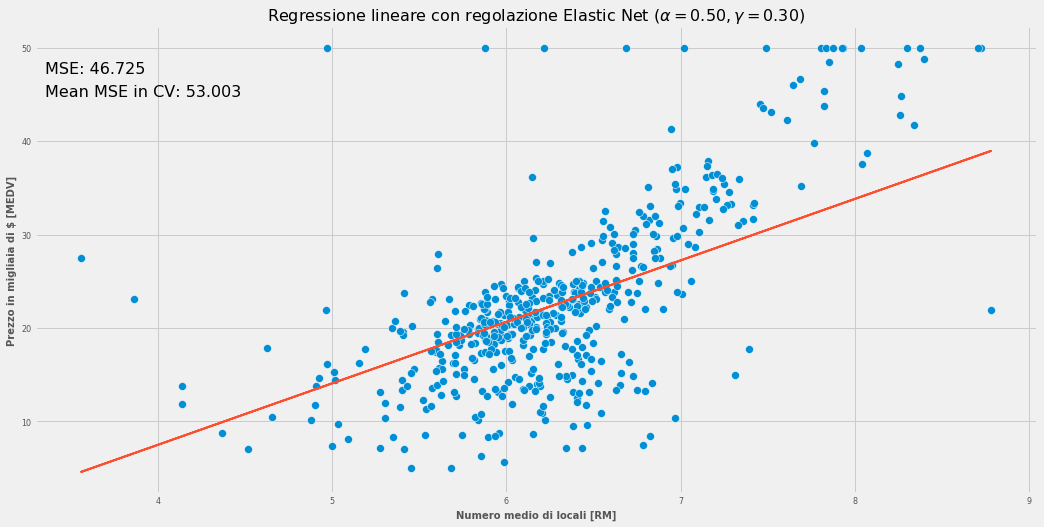

In [27]:
mse = mean_squared_error(r.predict(X),y)
mse_cv = -scores.mean()
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[0], edgecolor='white')
plt.plot(X, r.predict(X), color=colors[1]) 
plt.text(0.01,0.9, r'MSE: {0:.3f}'.format(mse), transform = ax.transAxes, size=16)
plt.text(0.01,0.85, r'Mean MSE in CV: {0:.3f}'.format(mse_cv), transform = ax.transAxes, size=16)
plt.xlabel('Numero medio di locali [RM]')
plt.ylabel('Prezzo in migliaia di $ [MEDV]')
plt.title(r'Regressione lineare con regolazione Elastic Net ($\alpha={0:.2f}, \gamma={1:.2f}$)'.format(alpha, gamma), fontsize=16)
plt.show()

## Funzioni base polinomiali

Regressione lineare standard con funzioni base polinomiali

In [28]:
deg = 8
pipe_regr = Pipeline([('scaler', StandardScaler()),('bf', PolynomialFeatures(degree=deg)),('regression', LinearRegression())])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')

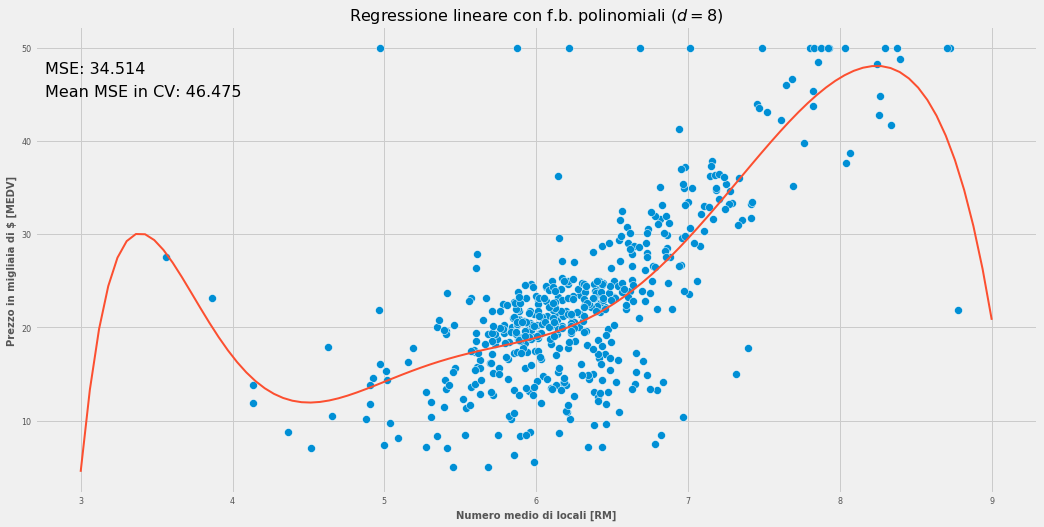

In [29]:
mse = mean_squared_error(r.predict(X),y)
mse_cv = -scores.mean()
xmin = np.floor(min(X)[0])
xmax = np.ceil(max(X)[0])
x = np.linspace(xmin,xmax,100).reshape(-1, 1)
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[0], edgecolor='white')
plt.plot(x, r.predict(x), color=colors[1]) 
plt.text(0.01,0.9, r'MSE: {0:.3f}'.format(mse), transform = ax.transAxes, size=16)
plt.text(0.01,0.85, r'Mean MSE in CV: {0:.3f}'.format(mse_cv), transform = ax.transAxes, size=16)
plt.xlabel('Numero medio di locali [RM]')
plt.ylabel('Prezzo in migliaia di $ [MEDV]')
plt.title(r'Regressione lineare con f.b. polinomiali ($d={0:3d}$)'.format(deg), fontsize=16)
plt.show()

Visualizzazione dei residui: differenze $y_i-t_i$ in funzione di $y_i$

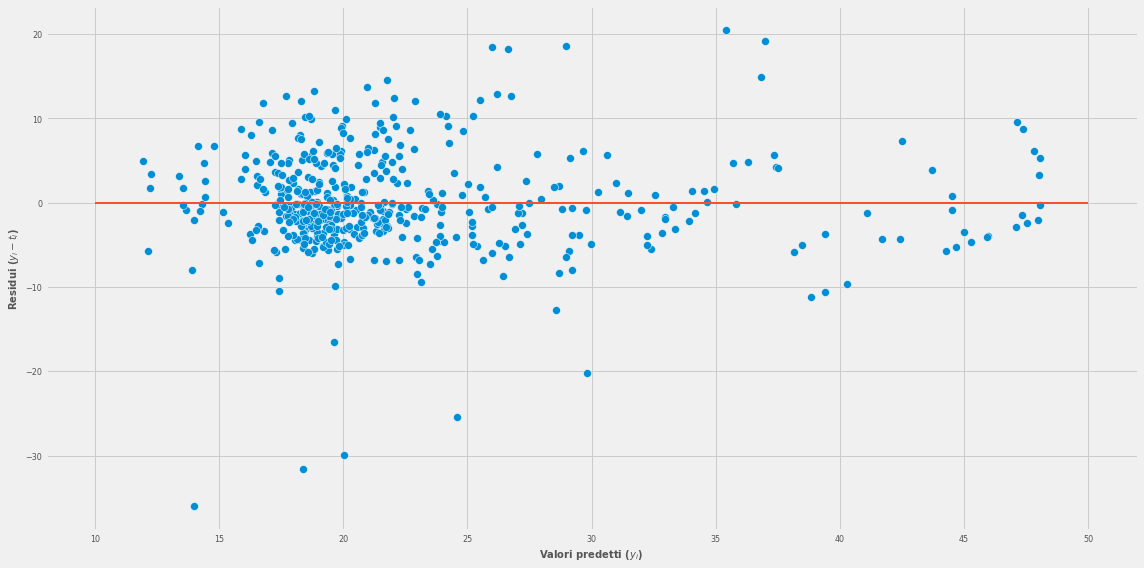

In [30]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y),
            c=colors[0], edgecolor='white',
            label='Train')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[1], lw=2)
plt.tight_layout()
plt.show()

In [42]:
alpha = 0.5
deg = 2
pipe_regr = Pipeline([('scaler', StandardScaler()),('bf', PolynomialFeatures(degree=deg)),('regression', Lasso(alpha=alpha))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')

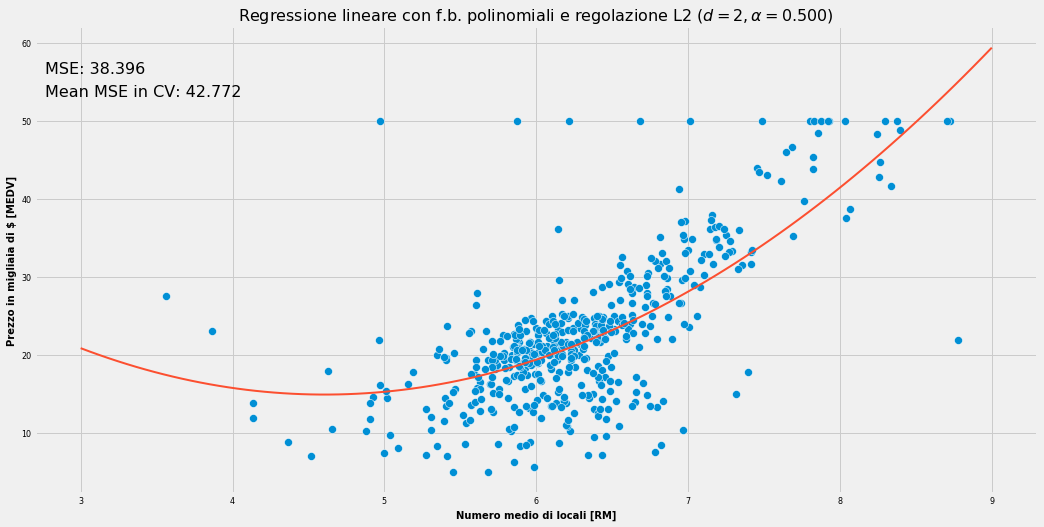

In [43]:
mse = mean_squared_error(r.predict(X),y)
mse_cv = -scores.mean()
xmin = np.floor(min(X)[0])
xmax = np.ceil(max(X)[0])
x = np.linspace(xmin,xmax,100).reshape(-1, 1)
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(X, y, c=colors[0], edgecolor='white')
plt.plot(x, r.predict(x), color=colors[1]) 
plt.text(0.01,0.9, r'MSE: {0:.3f}'.format(mse), transform = ax.transAxes, size=16)
plt.text(0.01,0.85, r'Mean MSE in CV: {0:.3f}'.format(mse_cv), transform = ax.transAxes, size=16)
plt.xlabel('Numero medio di locali [RM]')
plt.ylabel('Prezzo in migliaia di $ [MEDV]')
plt.title(r'Regressione lineare con f.b. polinomiali e regolazione L2 ($d={0:3d}, \alpha={1:.3f}$)'.format(deg, alpha), fontsize=16)
plt.show()

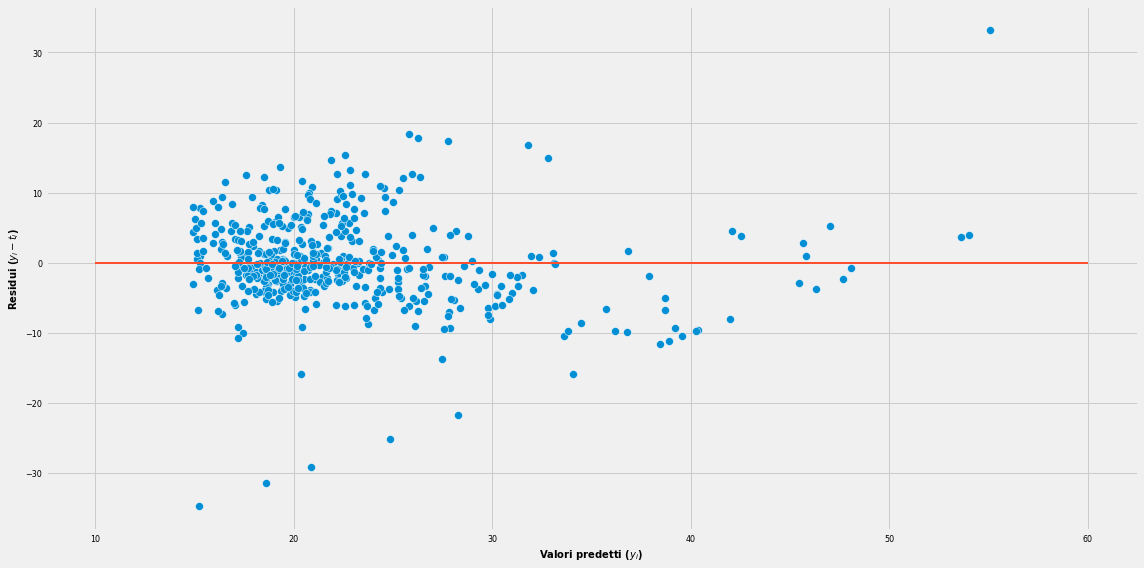

In [44]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y),
            c=colors[0], edgecolor='white',
            label='Train')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[1], lw=2)
plt.tight_layout()
plt.show()

## Regressione su tutte le feature

In [62]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [46]:
r = LinearRegression()
r.fit(X, y)
print('MSE: {0:.3f}'.format(mean_squared_error(r.predict(X),y)))

MSE: 21.895


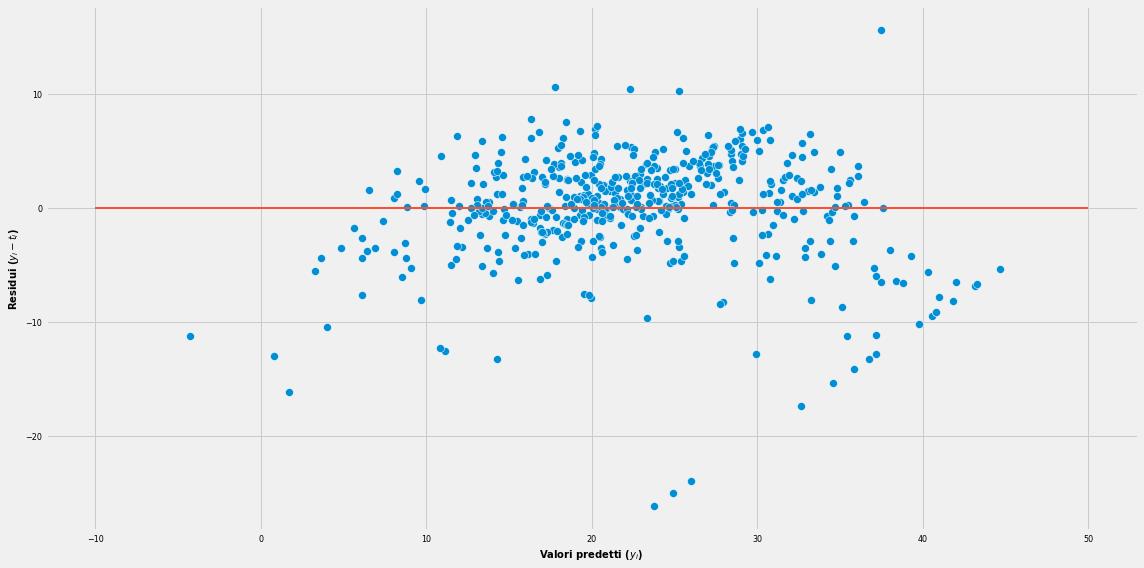

In [47]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y),
            c=colors[0], edgecolor='white',
            label='Train')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[1], lw=2)
plt.tight_layout()
plt.show()

In [48]:
r = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
r.fit(X, y)
print('MSE: {0:.3f}'.format(mean_squared_error(r.predict(X),y)))

MSE: 21.895


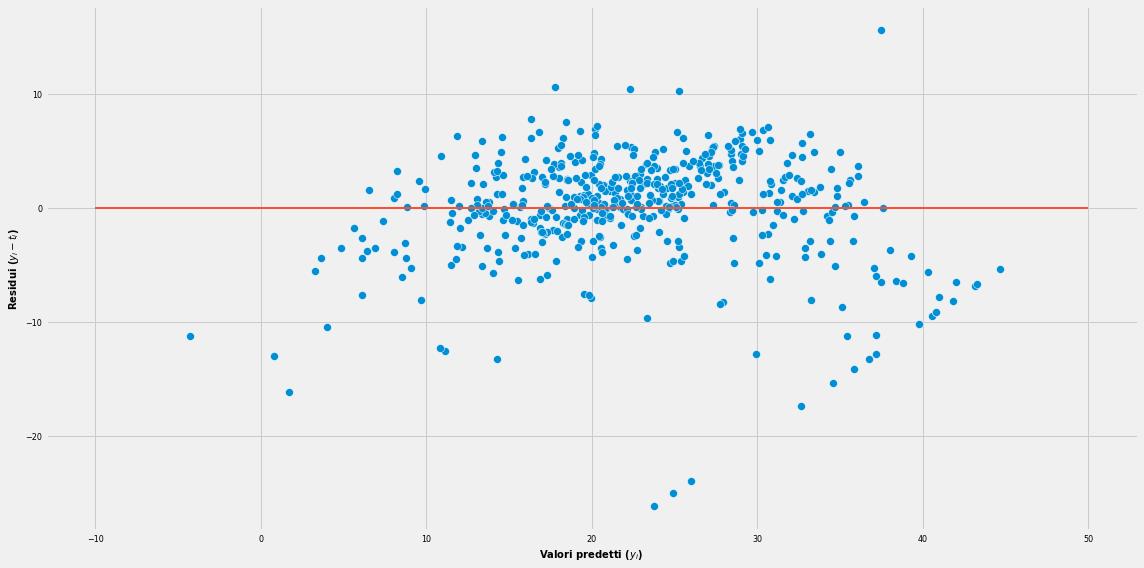

In [49]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y),
            c=colors[0], edgecolor='white',
            label='Train')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[1], lw=2)
plt.tight_layout()
plt.show()

In [50]:
r = Pipeline([('scaler', StandardScaler()),('regression', LinearRegression())])
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 34.705


In [52]:
alpha = 0.5
r = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha=alpha))])
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 35.698


In [53]:
alpha = 0.5
r = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha=alpha))])
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 34.635


In [54]:
alpha = 0.5
gamma = 0.3
r = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha=alpha, l1_ratio=gamma))])
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 32.697


In [55]:
pipe_regr = Pipeline([('scaler', StandardScaler()),('regression', LassoCV(cv=20))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
best_alpha = pipe_regr.named_steps['regression'].alpha_
print(r'Miglior valore di alpha: {0:.3f}'.format(best_alpha))
print('MSE: {0:.3f}'.format(-scores.mean()))

Miglior valore di alpha: 0.031
MSE: 34.237


In [56]:
pipe_regr = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha = best_alpha))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 34.266


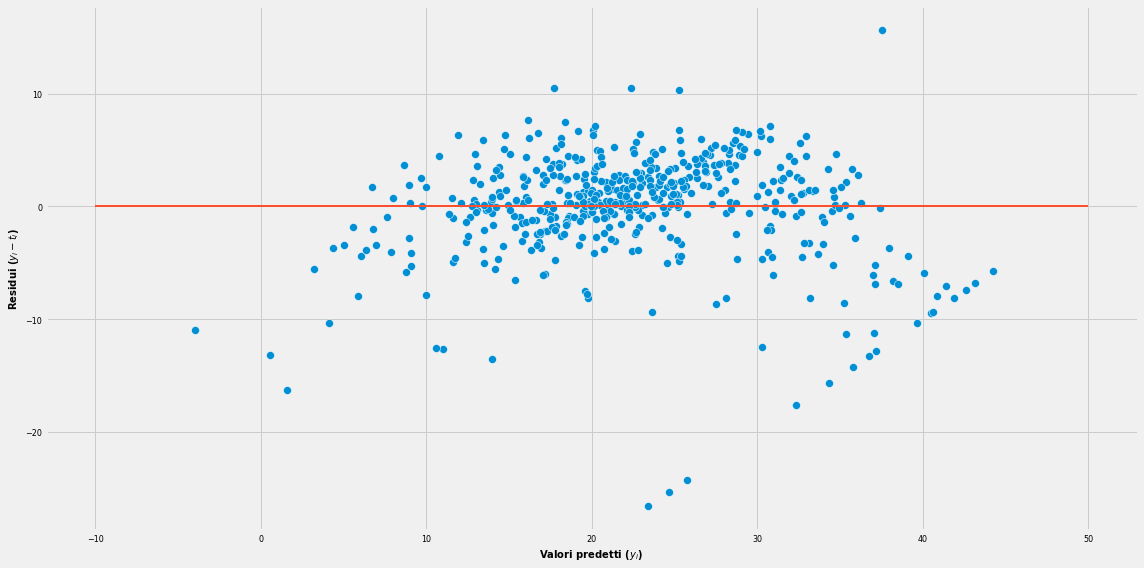

In [57]:
y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y),
            c=colors[0], edgecolor='white',
            label='Train')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[1], lw=2)
plt.tight_layout()
plt.show()

In [58]:
pipe_regr = Pipeline([('scaler', StandardScaler()),('regression', RidgeCV(cv=20))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
best_alpha = pipe_regr.named_steps['regression'].alpha_
print(r'Miglior valore di alpha: {0:.3f}'.format(best_alpha))
print('MSE: {0:.3f}'.format(-scores.mean()))

Miglior valore di alpha: 10.000
MSE: 33.564


In [59]:
pipe_regr = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha = best_alpha))])
r = pipe_regr.fit(X, y)
scores = cross_val_score(estimator=r, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 33.564


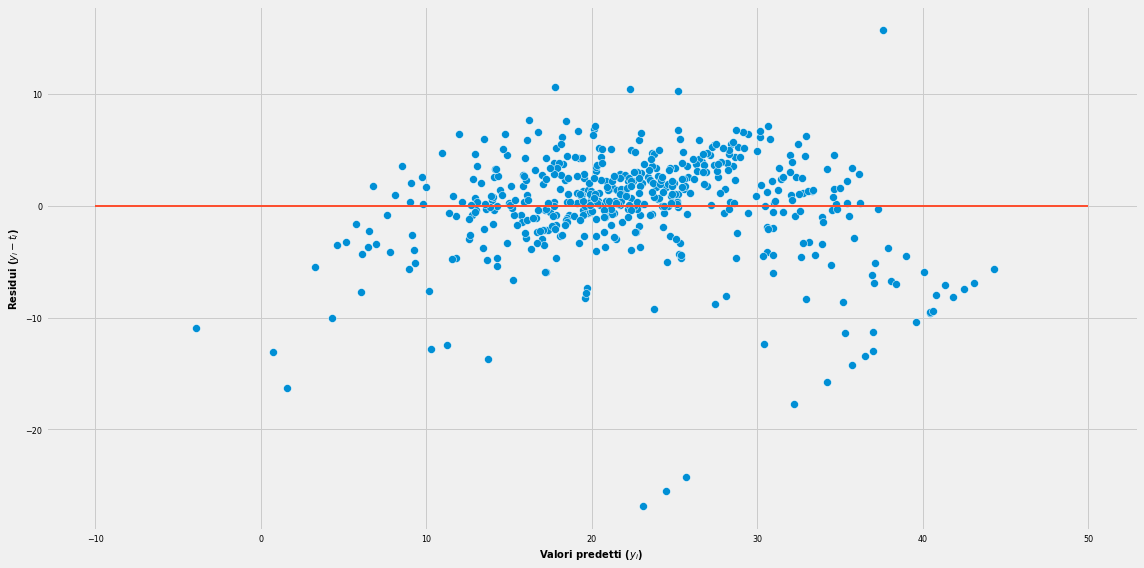

In [60]:
 r = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha=best_alpha))]).fit(X, y)

y_pred = r.predict(X)

mm = min(y_pred)
mx = max(y_pred)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.scatter(y_pred,  (y_pred - y),
            c=colors[0], edgecolor='white',
            label='Train')
plt.xlabel(r'Valori predetti ($y_i$)')
plt.ylabel(r'Residui ($y_i-t_i$)')
plt.hlines(y=0, xmin=(int(mm)/10)*10, xmax=(int(mx)/10)*10+10, color=colors[1], lw=2)
plt.tight_layout()
plt.show()

## Model selection

In [64]:
X = np.array(df[df.columns[:-1]])
y = np.array(df[df.columns[-1]])

### Lasso

Ricerca su griglia di valori per alpha in Lasso

In [65]:
domain = np.linspace(0,10,100)
cv = 10
scores = []
kf = KFold(n_splits=cv)
for a in domain:
    p = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha=a))])
    xval_err = 0
    for k, (train_index, test_index) in enumerate(kf.split(X,y)):
        p.fit(X[train_index], y[train_index])
        y1 = p.predict(X[test_index])
        err = y1 - y[test_index]
        xval_err += np.dot(err,err)
    score = xval_err/X.shape[0]
    scores.append([a,score])
scores = np.array(scores)

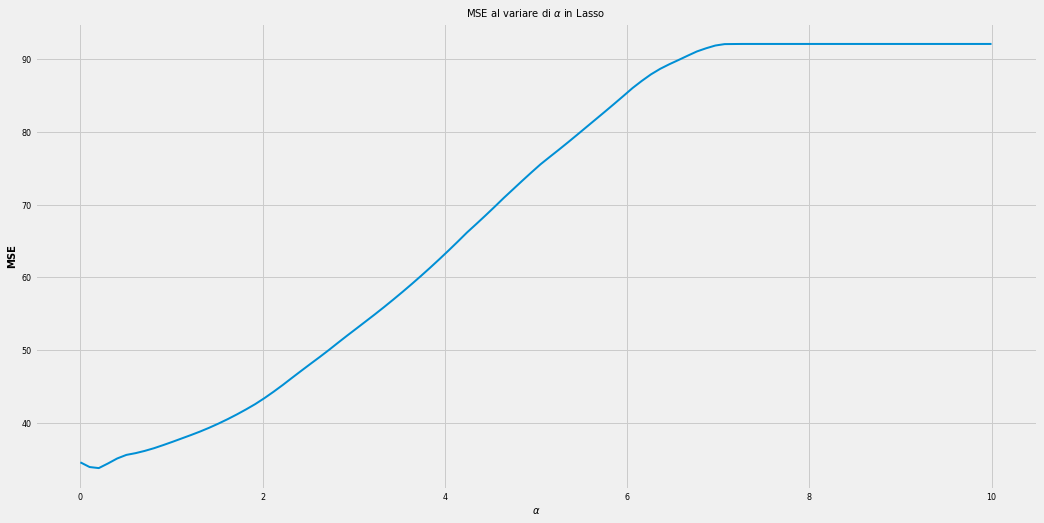

In [66]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(scores[:,0], scores[:,1]) 
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title(r'MSE al variare di $\alpha$ in Lasso')
plt.show()

In [503]:
min_index = np.argmin(scores[:,1])
print('Miglior valore per alpha: {0:.5f}. MSE={1:.3f}'.format(scores[min_index,0], scores[min_index,1]))

Miglior valore per alpha: 0.20202. MSE=33.748


Utilizzo di GridSearchCV

In [504]:
domain = np.linspace(0,10,100)
param_grid = [{'regression__alpha': domain}]
p = Pipeline([('scaler', StandardScaler()),('regression', Lasso())])

clf = GridSearchCV(p, param_grid, cv=5, scoring='neg_mean_squared_error')
clf = clf.fit(X,y)
sc = -clf.cv_results_['mean_test_score']

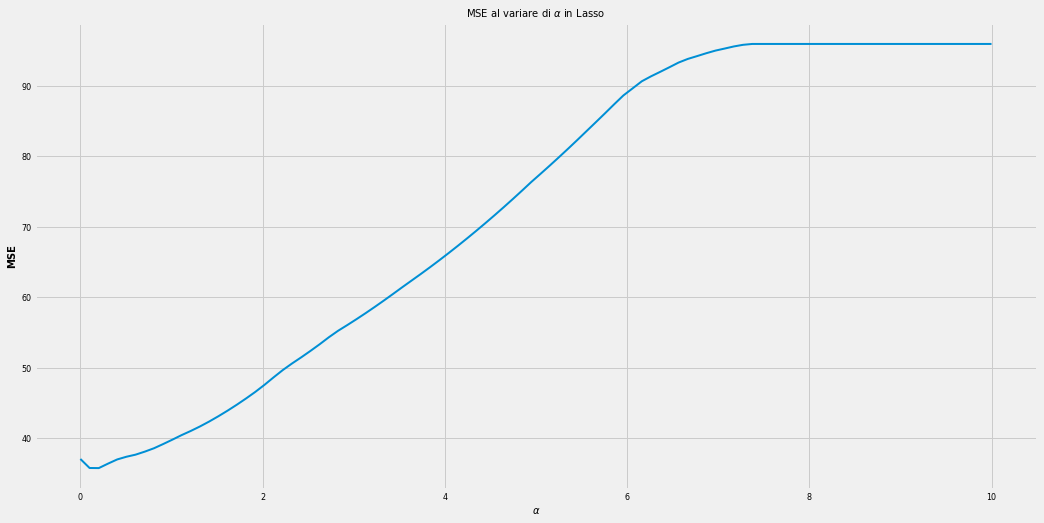

In [505]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(domain,sc) 
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title(r'MSE al variare di $\alpha$ in Lasso')
plt.show()

In [506]:
min_index = np.argmin(sc)
print('Miglior valore per alpha: {0:.5f}. MSE={1:.3f}'.format(domain[min_index], sc[min_index]))

Miglior valore per alpha: 0.20202. MSE=35.791


Utilizzo di LassoCV, che ricerca il miglior valore di $\alpha$ valutando lo score su un insieme di possibili valori mediante cross validation. 

In [507]:
domain=np.linspace(0,10,100)
p = Pipeline([('scaler', StandardScaler()),('regression', LassoCV(cv=10, alphas=domain))])
r = p.fit(X, y)
scores = np.mean(r.named_steps['regression'].mse_path_, axis=1)

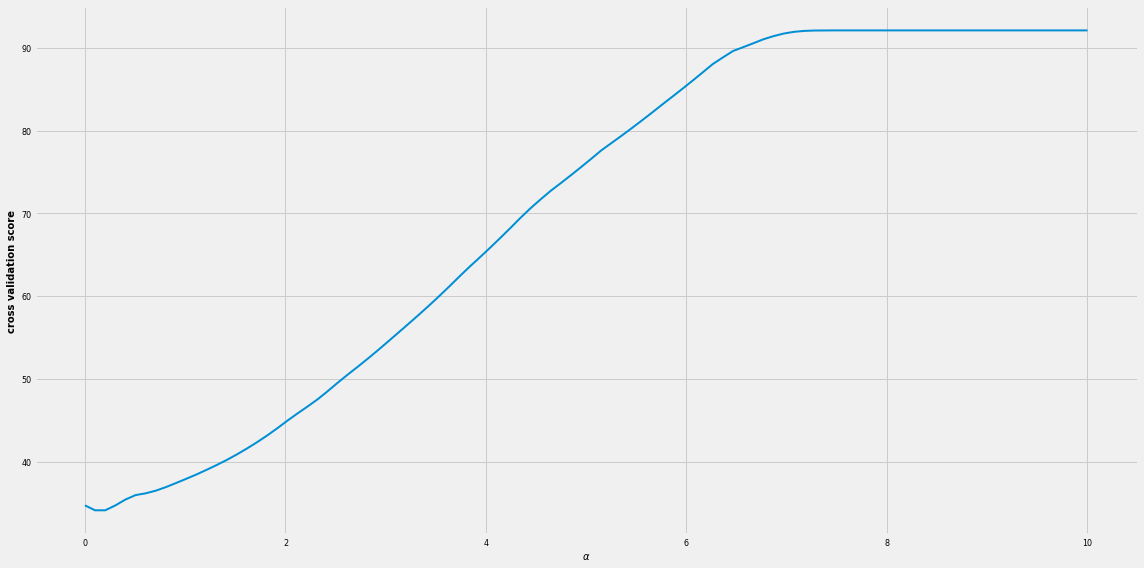

In [508]:
plt.figure(figsize=(16, 8))
plt.plot(r.named_steps['regression'].alphas_, scores)
plt.xlabel(r'$\alpha$')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [509]:
best_alpha = r.named_steps['regression'].alpha_
print(r'Miglior valore di alpha: {0:.5f}'.format(best_alpha))
i, = np.where(r.named_steps['regression'].alphas_ == best_alpha)
print('MSE: {0:.5f}'.format(scores[i][0]))

Miglior valore di alpha: 0.10101
MSE: 34.11086


In [472]:
r.named_steps['regression'].coef_

array([-0.62930101,  0.70478583, -0.        ,  0.6572789 , -1.56979387,
        2.82785277, -0.        , -2.41484202,  1.18178304, -0.83505174,
       -1.92124196,  0.76130577, -3.72616312])

Valuta Lasso con il valore trovato per $\alpha$ sull'intero dataset

In [510]:
p = Pipeline([('scaler', StandardScaler()),('regression', Lasso(alpha = best_alpha))])
scores = cross_val_score(estimator=p, X=X, y=y, cv=20, scoring='neg_mean_squared_error')
print('MSE: {0:.3f}'.format(-scores.mean()))

MSE: 31.935


### Ridge

Ricerca su griglia di valori per alpha in Ridge

In [512]:
domain = np.linspace(80,120,100)
cv = 10
scores = []
kf = KFold(n_splits=cv)
for a in domain:
    p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha=a))])
    xval_err = 0
    for k, (train_index, test_index) in enumerate(kf.split(X,y)):
        p.fit(X[train_index], y[train_index])
        y1 = p.predict(X[test_index])
        err = y1 - y[test_index]
        xval_err += np.dot(err,err)
    score = xval_err/X.shape[0]
    scores.append([a,score])
scores = np.array(scores)

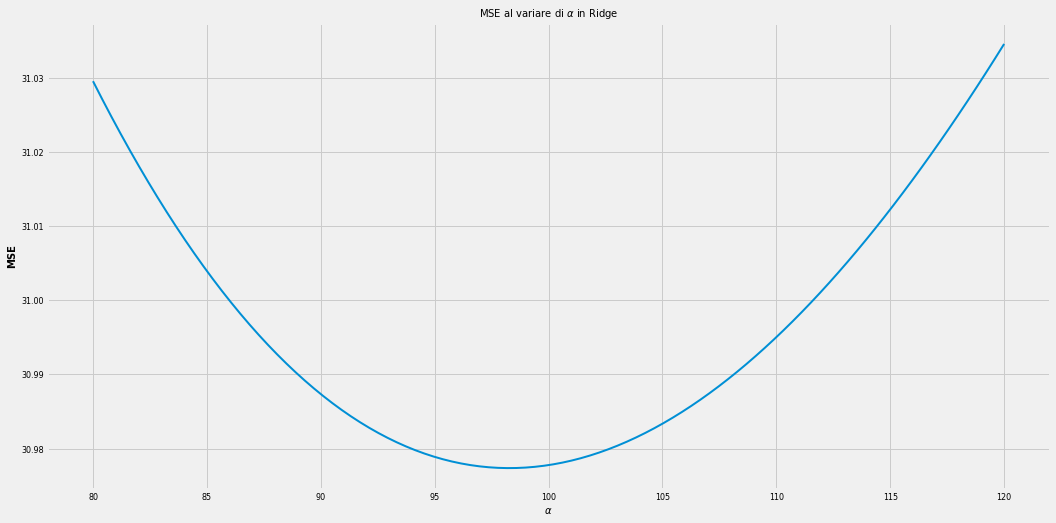

In [513]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(scores[:,0], scores[:,1]) 
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title(r'MSE al variare di $\alpha$ in Ridge')
plt.show()

In [514]:
min_index = np.argmin(scores[:,1])
best_alpha = scores[min_index,0]
print('Miglior valore per alpha: {0:.5f}. MSE={1:.3f}'.format(scores[min_index,0], scores[min_index,1]))

Miglior valore per alpha: 98.18182. MSE=30.977


Applica sul dataset con il valore trovato per $\alpha$

In [515]:
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha = best_alpha))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, MSE: {1:.3f}'.format(best_alpha, -scores.mean()))

alpha: 98.182, MSE: 31.098


Utilizzo di GridSearchCV

In [516]:
domain = np.linspace(80,120,100)
param_grid = [{'regression__alpha': domain}]
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge())])

clf = GridSearchCV(p, param_grid, cv=10, scoring='neg_mean_squared_error')
clf = clf.fit(X,y)
scores = -clf.cv_results_['mean_test_score']

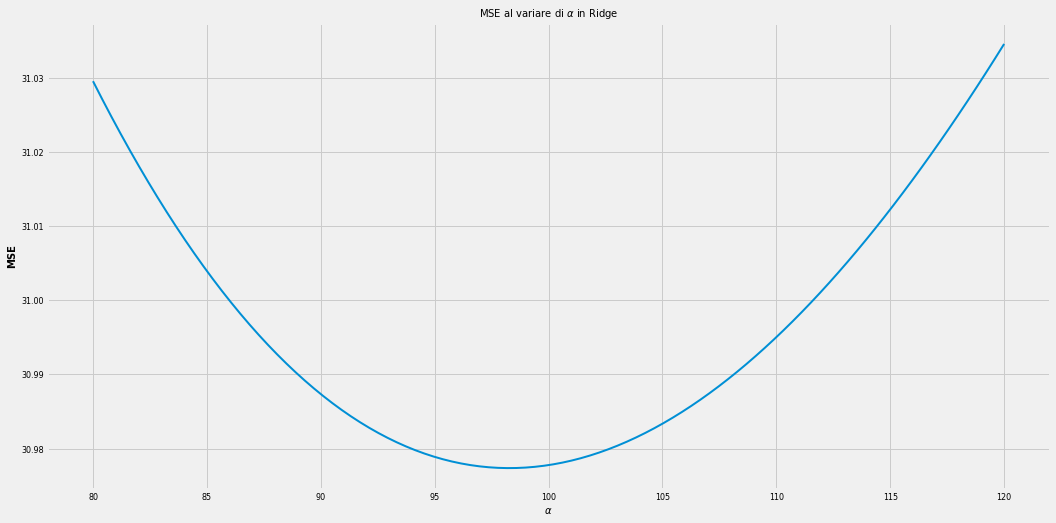

In [517]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(domain,scores) 
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title(r'MSE al variare di $\alpha$ in Ridge')
plt.show()

In [518]:
min_index = np.argmin(scores)
print('Miglior valore per alpha: {0:.5f}. MSE={1:.3f}'.format(domain[min_index], scores[min_index]))

Miglior valore per alpha: 98.18182. MSE=30.977


Applica sul dataset con il valore trovato per $\alpha$

In [519]:
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha = best_alpha))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, MSE: {1:.3f}'.format(best_alpha, -scores.mean()))

alpha: 98.182, MSE: 31.098


Utilizza RidgeCV, che ricerca il miglior valore di $\alpha$ valutando lo score su un insieme di possibili valori mediante cross validation

In [520]:
domain = np.linspace(0.1, 10, 100)
p = Pipeline([('scaler', StandardScaler()),('regression', RidgeCV(alphas=domain, store_cv_values = True))])
r = p.fit(X, y)
scores = np.mean(r.named_steps['regression'].cv_values_, axis=0)

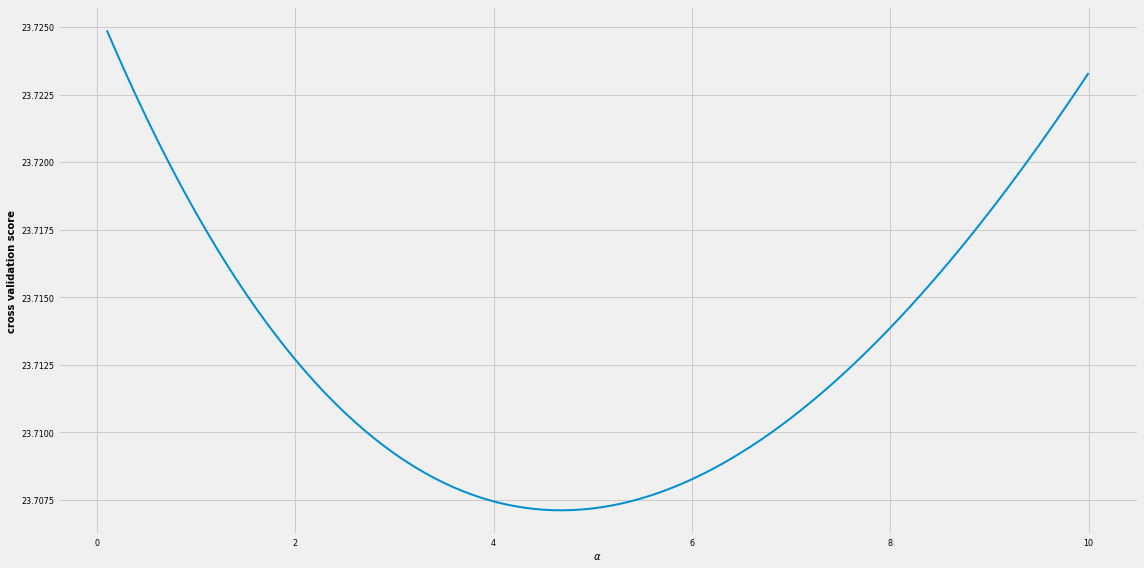

In [522]:
plt.figure(figsize=(16, 8))
plt.plot(domain, scores)
plt.xlabel(r'$\alpha$')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [523]:
best_alpha = p.named_steps['regression'].alpha_
print(r'Miglior valore di alpha: {0:.6f}'.format(best_alpha))
i, = np.where(domain == best_alpha)
print('score: {0:.3f}'.format(scores[i][0]))

Miglior valore di alpha: 4.700000
score: 23.707


Valuta Ridge con il valore trovato per  α
  sull'intero dataset

In [526]:
p = Pipeline([('scaler', StandardScaler()),('regression', Ridge(alpha = best_alpha))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, MSE: {1:.3f}'.format(best_alpha, -scores.mean()))

alpha: 4.700, MSE: 34.106


In [298]:
r.named_steps['regression'].coef_

array([-0.89235122,  1.01611022,  0.0424717 ,  0.69587883, -1.93388596,
        2.71049111, -0.0076361 , -2.98298414,  2.36253863, -1.79998461,
       -2.0241081 ,  0.8472428 , -3.68504643])

### Elastic net

Ricerca su griglia 2d di valori per $\alpha$ e $\gamma$

In [551]:
scores = []
for a in np.linspace(0,1,10):
    for l in np.linspace(0,1,10):
        p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha=a, l1_ratio=l))])
        score = cross_val_score(estimator=p, X=X, y=y, cv=5, scoring='neg_mean_squared_error')
        scores.append([a,l,-score.mean()])

In [552]:
scores = np.array(scores)
min_index = np.argmin(scores[:,2])
best_alpha = scores[min_index, 0]
best_gamma = scores[min_index, 1]
print(r"Migliore coppia: alpha={0:.2f}, gamma={1:.2f}. MSE={2:.3f}".format(best_alpha,best_gamma, scores[min_index,2]))


Migliore coppia: alpha=0.22, gamma=0.00. MSE=32.151


In [553]:
p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha = best_alpha, l1_ratio=best_gamma))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, gamma: {1:.3f}; MSE: {2:.3f}'.format(best_alpha, best_gamma, -scores.mean()))

alpha: 0.222, gamma: 0.000; MSE: 31.094


Utilizza GridsearchCV

In [68]:
param_grid = [{'regression__alpha': np.linspace(0,1,10), 'regression__l1_ratio': np.linspace(0,1,10)}]
p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha=alpha, l1_ratio=gamma))])

clf = GridSearchCV(p, param_grid, cv=5, scoring='neg_mean_squared_error')
clf = clf.fit(X,y)
sc = -clf.cv_results_['mean_test_score']

In [557]:
best_alpha = clf.best_params_['regression__alpha']
best_gamma = clf.best_params_['regression__l1_ratio']
print(r"Migliore coppia: alpha={0:.2f}, gamma={1:.2f}. MSE={2:.3f}".format(best_alpha,
                                        best_gamma, -clf.best_score_))

Migliore coppia: alpha=0.22, gamma=0.00. MSE=32.107


In [67]:
p = Pipeline([('scaler', StandardScaler()),('regression', ElasticNet(alpha = best_alpha, l1_ratio=best_gamma))])
r = p.fit(X, y)
scores = cross_val_score(estimator=p, X=X, y=y, cv=10, scoring='neg_mean_squared_error')
print('alpha: {0:.3f}, gamma: {1:.3f}; MSE: {2:.3f}'.format(best_alpha, best_gamma, -scores.mean()))

NameError: name 'best_gamma' is not defined